# Generate Data

In [17]:
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import manhattan_distances


def generate_data():
    return make_classification(n_samples=n_obs, 
                           n_features=5, 
                           n_informative=3, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=3, 
                           weights=None, 
                           flip_y=0.05,
                           class_sep=0.5,
                           hypercube=True,
                           shift=0.0,
                           scale=1.0,
                           shuffle=True,
                           random_state=None)

def real_data():
    skip = sorted(random.sample(range(1, n_obs), int(n_obs/2)))
    df = pd.read_csv('creditdefault_train.csv',
                    header=0,
                    nrows=n_obs,
                    skiprows=skip)#[3, 34, 4])#lambda x: random.random()>0.5 if x>0 else False)
    to_keep = ['LIMIT_BAL', 'AGE',
               'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
               'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
               'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',]
    print('Columns kept:', to_keep)    
    return np.array(df[to_keep].apply(pd.to_numeric)), np.array(df.iloc[:, -1])




'''
NUMBER OF OBSERVATIONS AND FEATURES
'''
n_obs = 1000
#n_features = 25

#X, y = generate_data()
X, y = real_data()

'''
SCALE BETWEEN -1; 1
'''
X = (X - X.mean(axis=0))
X = X / list(map(max, zip(abs(X.max(axis=0)), abs(X.min(axis=0)))))


print(y.mean())


Columns kept: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
0.216


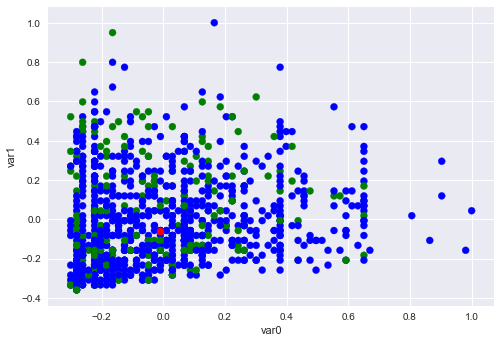

In [41]:
AX1, AX2 = 0, 1

#2D plot
plt.scatter(X[:, AX1], X[:, AX2], color=[['blue', 'green'][int(i)] for i in y])
if 'idx' in globals() and idx <= X.shape[0]:
    plt.scatter(X[idx,AX1], X[idx, AX2], color='red')
plt.xlabel('var0')
plt.ylabel('var1')
plt.show()

# Train a Classifier

In [25]:
from __future__ import print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score



X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = RandomForestClassifier(100)
#clf = SVC(probability=True)
#clf = SGDClassifier('modified_huber')
#clf = MLPClassifier(activation='relu')
#clf = BernoulliRBM()
'''logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)
clf = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
'''
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_p = clf.predict_proba(X_test)

print('accuracy ', sum(y_pred == y_test)/len(y_test))
print('auc ', roc_auc_score(y_test, y_pred))

#clf.feature_importances_

accuracy  0.788
auc  0.592543859649


True

# LIME

In [82]:
idx_test = np.random.randint(X_test.shape[0])
idx = int(np.where(np.all(X_test[idx_test] == X, axis=1))[0])

In [27]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=['var' + str(i) for i in range(X.shape[1])],#, 'var3'],
                                                   #class_names=list(map(str, iris.target_names)),
                                                   discretize_continuous=False,
                                                   verbose=True)
exp = explainer.explain_instance(X_test[idx_test], clf.predict_proba, num_features=10, top_labels=1)
print('score du fit du local au global', exp.score)



exp.show_in_notebook(show_table=True, show_all=False)

Intercept 0.687822237076
Prediction_local [ 0.74809223]
Right: 0.83
score du fit du local au global 0.226257864198


# TEST

In [83]:
'''
FUNCTIONS
'''
def pred(obs):
    return clf.predict_proba(obs.reshape(1, -1))[0][1]

def same_class(obs1, obs2):
    return clf.predict(obs1.reshape(1,-1))[0] == clf.predict(obs2.reshape(1,-1))[0]

def is_outlier(data, obs, q):
    out = False
    for f in range(X.shape[1]):
        val = obs[f]
        limit_10 = np.percentile(data[:, f], q)
        limit_90 = np.percentile(data[:, f], 100 - q)
        if val > limit_90 or val < limit_10:
            out = True
            print('outlier in var', f)
            break
    return out



from sklearn.svm import OneClassSVM
clf_outlier = OneClassSVM().fit(X)
def is_outlierSVM(obs):
    return int(clf_outlier.predict(obs.reshape(1, -1))[0]) #1 = not outlier, -1=outlier

print(is_outlier(X, X[idx], 10))
print(is_outlierSVM(X[idx]))


False
1


0.38


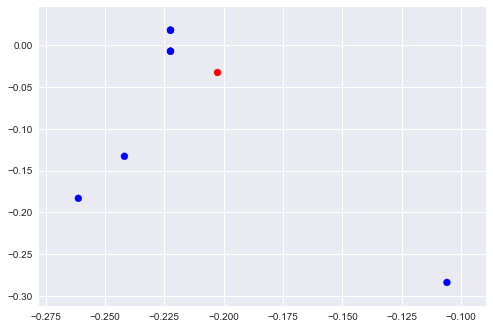

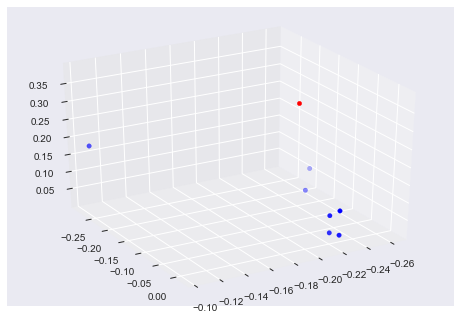

In [90]:
'''
PLOT VOISINS 2D + 3D (avec proba)
'''


from sklearn.metrics.pairwise import pairwise_distances
D = pairwise_distances(X, X[idx].reshape(1, -1), metric='euclidean', n_jobs=-1)
idxes = [x[0] for x in sorted(enumerate(D), key=lambda y:y[1])]
print(pred(X[idx]))
nn = 8
AX1, AX2 = 0 ,1


plt.scatter([X[x][AX1] for x in idxes[1:nn]], [X[x][AX2] for x in idxes[1:nn]], color=[['blue', 'green'][clf.predict(X[x].reshape(1,-1))[0]] for x in idxes[1:nn]])
plt.scatter(X[idx][AX1], X[idx][AX2], color='red')
plt.show()



from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter([X[x][AX1] for x in idxes[1:nn]], 
           [X[x][AX2] for x in idxes[1:nn]], 
           [pred(X[x]) for x in idxes[1:nn]], 
           zdir='z', s=20, depthshade=True, 
           color=[['blue', 'green',][int(i>0.5)] for i in [pred(X[x]) for x in idxes[1:nn]]])
ax.scatter(X[idx,AX1], X[idx, AX2], pred(X[idx]), color='red')
ax.view_init(30, 60)
plt.show()

7
0 0 7
8
1 1e-05 15
11
2 2e-05 26
9
3 3.0000000000000004e-05 35
9
4 4e-05 44
14
5 5e-05 58
13
6 6e-05 71
7
7 7.000000000000001e-05 78
8
8 8e-05 86
12
9 9e-05 98
7
10 0.0001 105


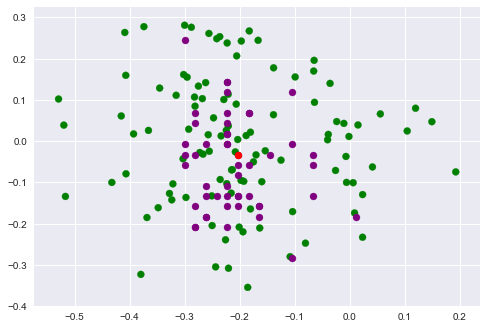

"ennemies = sorted(ennemies, key=lambda x: manhattan_distances(x[:-1], X_test[idx]))\n\nfor border in ennemies:\n    print('In order to join its neighbour, our observation would need:')\n    for v in range(X_test.shape[1]):\n        print('%f in variable %d (value= %f); Range= (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[idx,v], X_test[:, v].min(), X_test[:, v].max()))\n\n"

In [103]:
#idx = np.random.randint(X_test.shape[0])
''' 
FAIRE GRANDIR BOULES
'''
#import random
from numpy import random
from math import pi, cos, sin
#from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import manhattan_distances

'''idx_test = np.random.randint(X_test.shape[0])
idx = int(np.where(np.all(X_test[idx_test] == X, axis=1))[0])'''

AX1, AX2 = 0, 1


def generate_inside_ball(center, d, segment=(0,1)):
    #genere une observation de dimension d dans la "boule" de centre center et de rayon segment
    def norm(v):
        return sum(map(lambda x: x**2, v))**(0.5)
    z = random.normal(0, 1, d)
    z = z/norm(z) * random.uniform(*segment)**(1/float(d))
    z += center
    return z


def generate_inside_manhattan(center, d, segment=(0,1)):
    return 0

def generate_layer_with_pred(center, d, n, segment):
    #generer n observations avec la pred
    out = []
    for i in range(n):
        a = generate_inside_ball(center, d, segment=segment)
        pred = clf.predict(a.reshape(1, -1))
        a = list(a)
        a.append(pred)
        out.append(a)
    return np.array(out)


###GENERE SPHERES A LA SUITE DE PLUS EN PLUS GRANDES; S ARRETE QUAND A TROUVE LE NOMBRE VOULU D ENNEMIS

def seek_ennemies():
    N_LAYER = 500
    STEP=1/100000.0
    ENOUGH_ENNEMIES = 100
    PRED_CLASS = clf.predict(X[idx].reshape(1, -1))
    ennemies = []
    a0 = 0
    i = 0
    a1 = STEP
    while len(ennemies) < ENOUGH_ENNEMIES:
        layer_ = generate_layer_with_pred(X[idx], X.shape[1], n=N_LAYER, segment=(a0, a1))
        layer_enn = [x for x in layer_ if x[-1] == 1-PRED_CLASS]
        #layer_enn = [x for x in layer_ if (x[-1] == 1-PRED_CLASS) and (is_outlierSVM(x[:-1])==1)]
        #layer_enn = [x for x in layer_ if (x[-1] == 1-PRED_CLASS) and not (is_outlier(X, x[:-1], 5))]
        print(len([x for x in layer_ if (x[-1] == 1-PRED_CLASS) and (is_outlierSVM(x[:-1])==-1)]))
        ennemies.extend(layer_enn)
        print(i, a0, len(ennemies))
        i += 1
        a0 += STEP
        a1 += STEP
    return layer_, ennemies

layer_, ennemies = seek_ennemies()


#df = X
#plt.scatter([x[AX1] for x in layer_], [x[AX2] for x in layer_], color=[['blue', 'green'][int(x[-1])] for x in layer_])
plt.scatter([x[AX1] for x in ennemies], [x[AX2] for x in ennemies], color=[['blue', 'green'][int(x[-1])] for x in ennemies])
plt.scatter([df[x][AX1] for x in idxes[:50]], [df[x][AX2] for x in idxes[:50]], color='purple')
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.show()


'''ennemies = sorted(ennemies, key=lambda x: manhattan_distances(x[:-1], X_test[idx]))

for border in ennemies:
    print('In order to join its neighbour, our observation would need:')
    for v in range(X_test.shape[1]):
        print('%f in variable %d (value= %f); Range= (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[idx,v], X_test[:, v].min(), X_test[:, v].max()))

'''

In [107]:
print(sum([is_outlier(X, x[:-1], 10) for x in ennemies])/len(ennemies))
print(sum([is_outlierSVM(x[:-1]) for x in ennemies])/len(ennemies))


outlier in var 7
outlier in var 0
outlier in var 2
outlier in var 2
outlier in var 0
outlier in var 2
outlier in var 7
outlier in var 0
outlier in var 5
outlier in var 6
outlier in var 2
outlier in var 0
outlier in var 0
outlier in var 0
outlier in var 2
outlier in var 2
outlier in var 5
outlier in var 2
outlier in var 5
outlier in var 3
outlier in var 7
outlier in var 0
outlier in var 0
outlier in var 0
outlier in var 2
outlier in var 2
outlier in var 5
outlier in var 2
outlier in var 0
outlier in var 2
outlier in var 2
outlier in var 2
outlier in var 1
outlier in var 2
outlier in var 5
outlier in var 1
outlier in var 0
outlier in var 0
outlier in var 2
outlier in var 3
outlier in var 1
outlier in var 0
outlier in var 5
outlier in var 0
outlier in var 8
outlier in var 0
outlier in var 0
outlier in var 0
outlier in var 2
outlier in var 2
outlier in var 2
outlier in var 5
outlier in var 2
outlier in var 5
outlier in var 2
outlier in var 7
outlier in var 2
outlier in var 2
outlier in var

proba red 0.38
proba orange 1.0


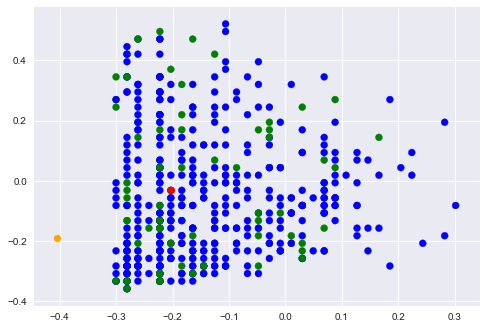

In [94]:

from sklearn.metrics.pairwise import pairwise_distances
ennemy = ennemies[0]
df=X
D = pairwise_distances(df, X[idx].reshape(1, -1), metric='euclidean', n_jobs=-1)
idxes = [x[0] for x in sorted(enumerate(D), key=lambda y:y[1])]
print('proba red', pred(X[idx]))
print('proba orange', ennemy[-1])
nn = 500
AX1, AX2 = 0 ,1


#plt.scatter([X[x][AX1] for x in idxes[:50]], [X[x][AX2] for x in idxes[:50]], color='purple')
plt.scatter([df[x][AX1] for x in idxes[:nn]], [df[x][AX2] for x in idxes[:nn]], color=[['blue', 'green'][int(pred(df[x])>0.5)] for x in idxes[:nn]])
plt.scatter(ennemy[AX1], ennemy[AX2], color='orange')
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.show()

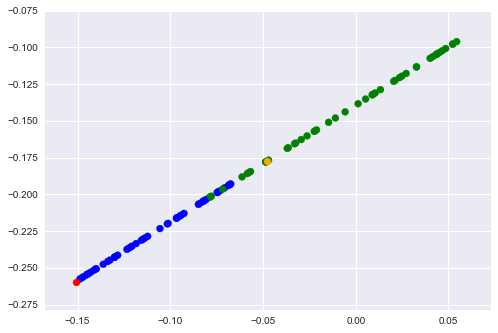

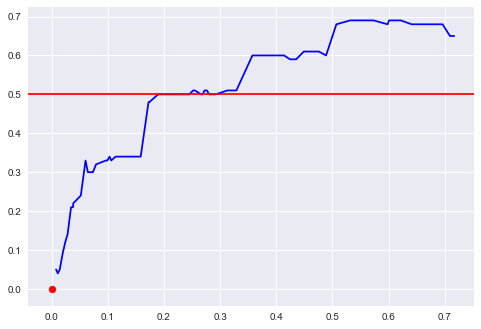

In [259]:
AX1, AX2 = 0, 1
def generate_segment(obs1, obs2, amax=1, n=100):
    news = []
    for i in range(n):
        a = random.random() * amax
        new = a * obs2 + (1 - a)*obs1
        news.append(new)
    return news

ennemy = ennemies[2]


genobs = generate_segment(X[idx], ennemy[:-1], 2, 100)
plt.scatter([x[AX1] for x in genobs], [x[AX2] for x in genobs], color=[['blue', 'green'][int(pred(x)>0.5)] for x in genobs])
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.scatter(ennemy[AX1], ennemy[AX2], color='orange')
plt.show()

from sklearn.metrics.pairwise import pairwise_distances
genobs = sorted(genobs, key=lambda x:pairwise_distances(X[idx].reshape(1, -1), x.reshape(1, -1))[0][0])
plt.plot(pairwise_distances(X[idx].reshape(1, -1), genobs, metric='euclidean')[0], [pred(x) for x in genobs], color='blue')
plt.scatter(0, 0, color='red')
plt.axhline(y=0.5, color='red')
#plt.scatter(0.06072482, 0, color='orange')
plt.show()



In [ ]:
pairwise_distances(ennemies[0][:-1], X[idx])

0 0 73


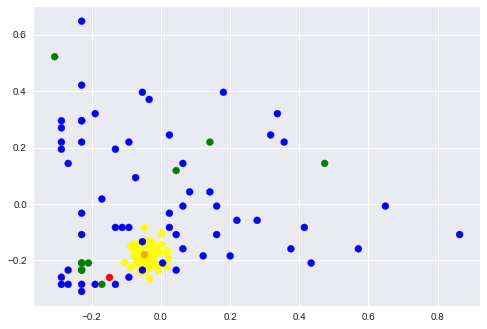

In [263]:
###GENERE SPHERES A LA SUITE DE PLUS EN PLUS GRANDES; S ARRETE QUAND A TROUVE LE NOMBRE VOULU D ENNEMIS
AX1, AX2 = 0, 1
N_LAYER = 100
STEP=1/100000000000000000.0
ENOUGH_ENNEMIES = 50
count_ennemies = 0
ennemies2 = []
a0 = 0
i = 0
a1 = STEP
while count_ennemies < ENOUGH_ENNEMIES:
    layer_ = generate_layer_with_pred(ennemy[:-1], X.shape[1], n=N_LAYER, segment=(a0, a1))
    count_ennemies += int(abs(int(sum(layer_[:, -1])) - N_LAYER*clf.predict(X[idx].reshape(1,-1))))
    ennemies2.extend([x for x in layer_ if x[-1] == 1-clf.predict(X[idx].reshape(1, -1))])
    print(i, a0, count_ennemies)
    #plt.scatter([x[AX1] for x in layer_], [x[AX2] for x in layer_], color=[['blue', 'green'][int(x[-1])] for x in layer_])
    i += 1
    a0 += STEP
    a1 += STEP

plt.scatter([x[AX1] for x in ennemies2], [x[AX2] for x in ennemies2], color='yellow')
plt.scatter([X[x][AX1] for x in idxes[:70]], [X[x][AX2] for x in idxes[:70]], color=[['blue', 'green'][int(pred(X[x])>0.5)] for x in idxes])
plt.scatter(ennemy[AX1], ennemy[AX2], color='orange')
plt.scatter(X[idx, AX1], X[idx, AX2], color='red')
plt.show()


# Testing this border with feature selection or other